<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

# Hierarchical Clustering

Estimated time needed: **25** minutes

## Objectives

After completing this lab you will be able to:

*   Use scikit-learn to Hierarchical clustering
*   Create dendograms to visualize the clustering


## Import necessary modules

In [72]:
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.datasets import make_blobs 
%matplotlib inline

<h1 id="clustering_vehicle_dataset">Clustering on Vehicle dataset</h1>

Imagine that an automobile manufacturer has developed prototypes for a new vehicle. Before introducing the new model into its range, the manufacturer wants to determine which existing vehicles on the market are most like the prototypes--that is, how vehicles can be grouped, which group is the most similar with the model, and therefore which models they will be competing against.

Our objective here, is to use clustering methods, to find the most distinctive clusters of vehicles. It will summarize the existing vehicles and help manufacturers to make decision about the supply of new models.


## Download data

To download the data, we will use **`!wget`** to download it from IBM Object Storage.\
**Did you know?** When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)


``` python
!wget -O cars_clus.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/data/cars_clus.csv
```

## Read data

Let's read dataset to see what features the manufacturer has collected about the existing models.


#1. Read data from IBM cloud
```python
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_d0c79363173c477b9e94780ac93a1869 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_d0c79363173c477b9e94780ac93a1869 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_d0c79363173c477b9e94780ac93a1869 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Y3po58xhOr-1BQDkgS86-Ymx9bfgWTozzi88KQZ9eWl8',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_d0c79363173c477b9e94780ac93a1869)

body = client_d0c79363173c477b9e94780ac93a1869.get_object(Bucket='ibmmachinelearningdsprofessionalc-donotdelete-pr-vxut8j4zkddur7',Key='cars_clus.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

pdf = pd.read_csv(body)
pdf.head()
```

In [73]:
#2. Read data from local machine 

filename = 'cars_clus.csv'

#Read csv
pdf = pd.read_csv(filename)
print ("Shape of dataset: ", pdf.shape)

pdf.head(5)

Shape of dataset:  (159, 16)


manufact    model   sales  resale   type   price engine_s horsepow wheelbas  \
0    Acura  Integra  16.919  16.360  0.000  21.500    1.800  140.000  101.200   
1    Acura       TL  39.384  19.875  0.000  28.400    3.200  225.000  108.100   
2    Acura       CL  14.114  18.225  0.000  $null$    3.200  225.000  106.900   
3    Acura       RL   8.588  29.725  0.000  42.000    3.500  210.000  114.600   
4     Audi       A4  20.397  22.255  0.000  23.990    1.800  150.000  102.600   

    width   length curb_wgt fuel_cap     mpg lnsales  partition  
0  67.300  172.400    2.639   13.200  28.000   2.828        0.0  
1  70.300  192.900    3.517   17.200  25.000   3.673        0.0  
2  70.600  192.000    3.470   17.200  26.000   2.647        0.0  
3  71.400  196.600    3.850   18.000  22.000   2.150        0.0  
4  68.200  178.000    2.998   16.400  27.000   3.015        0.0

The feature sets include  price in thousands (price), engine size (engine_s), horsepower (horsepow), wheelbase (wheelbas), width (width), length (length), curb weight (curb_wgt), fuel capacity (fuel_cap) and fuel efficiency (mpg).


<h2 id="data_cleaning">Data Cleaning</h2>

Let's clean the dataset by dropping the rows that have null value:


In [74]:
print ("Size of dataset before cleaning: ", pdf.size)

# to make sure the data for the selected columns are numeric, set to data to Nan if invalid prasing
# purpose of this convesion is for dropping Nan later 
# so at the end these colums contain numeric and Nan
pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
pdf = pdf.dropna()
pdf = pdf.reset_index(drop=True) # index of rows with NaN will be removed when .dropna() applied, so we have to reset it

print ("Size of dataset after cleaning: ", pdf.size)
pdf.head(5)

Size of dataset before cleaning:  2544
Size of dataset after cleaning:  1872


manufact    model   sales  resale  type  price  engine_s  horsepow  \
0    Acura  Integra  16.919  16.360   0.0  21.50       1.8     140.0   
1    Acura       TL  39.384  19.875   0.0  28.40       3.2     225.0   
2    Acura       RL   8.588  29.725   0.0  42.00       3.5     210.0   
3     Audi       A4  20.397  22.255   0.0  23.99       1.8     150.0   
4     Audi       A6  18.780  23.555   0.0  33.95       2.8     200.0   

   wheelbas  width  length  curb_wgt  fuel_cap   mpg  lnsales  partition  
0     101.2   67.3   172.4     2.639      13.2  28.0    2.828        0.0  
1     108.1   70.3   192.9     3.517      17.2  25.0    3.673        0.0  
2     114.6   71.4   196.6     3.850      18.0  22.0    2.150        0.0  
3     102.6   68.2   178.0     2.998      16.4  27.0    3.015        0.0  
4     108.7   76.1   192.0     3.561      18.5  22.0    2.933        0.0

### Feature selection

Let's select our feature set:


In [75]:
featureset = pdf[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]

### Normalization

Now we can normalize the feature set. **MinMaxScaler** transforms features by scaling each feature to a given range. It is by default (0, 1). That is, this estimator scales and translates each feature individually such that it is between zero and one.


In [76]:
from sklearn.preprocessing import MinMaxScaler

In [77]:
x = featureset.values #returns a numpy array

min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.30625832,
        0.2310559 , 0.13364055, 0.43333333],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.5792277 ,
        0.50372671, 0.31797235, 0.33333333],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.62849534,
        0.60714286, 0.35483871, 0.23333333],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.38082557,
        0.34254658, 0.28110599, 0.4       ],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.56724368,
        0.5173913 , 0.37788018, 0.23333333]])

<h2 id="clustering_using_scipy">Flat clustering with Scipy</h2>

### Dendrogram with distance matrix 

#### Distance matrix using `eucledian()`

In [78]:
import scipy
from scipy.spatial.distance import euclidean

In [79]:
leng = feature_mtx.shape[0] #get row of array
D = np.zeros([leng,leng]) #create distance matrix variables (both axis contain the same variables)
for i in range(leng): # can also use zip() to iterate two iterable
    for j in range(leng):
        D[i,j] = euclidean(feature_mtx[i], feature_mtx[j])
D

array([[0.        , 0.57777143, 0.75455727, ..., 0.28530295, 0.24917241,
        0.18879995],
       [0.57777143, 0.        , 0.22798938, ..., 0.36087756, 0.66346677,
        0.62201282],
       [0.75455727, 0.22798938, 0.        , ..., 0.51727787, 0.81786095,
        0.77930119],
       ...,
       [0.28530295, 0.36087756, 0.51727787, ..., 0.        , 0.41797928,
        0.35720492],
       [0.24917241, 0.66346677, 0.81786095, ..., 0.41797928, 0.        ,
        0.15212198],
       [0.18879995, 0.62201282, 0.77930119, ..., 0.35720492, 0.15212198,
        0.        ]])

Original tutorial did not transform matrix via `squareform`

In [80]:
D = squareform(D)
D

array([0.57777143, 0.75455727, 0.2128736 , ..., 0.41797928, 0.35720492,
       0.15212198])

#### `complete` Hierarchical linkage

In agglomerative clustering, at each iteration, the algorithm must update the distance matrix to reflect the distance of the newly formed cluster with the remaining clusters in the forest.
The following methods are supported in Scipy for calculating the distance between the newly formed cluster and each:
\- single
\- complete
\- average
\- weighted
\- centroid

We use **complete** for our case, but feel free to change it to see how the results change.


In [81]:
import scipy.cluster.hierarchy

In [82]:
Z = hierarchy.linkage(D, 'complete')

#### Dendrogram

In [83]:
import pylab

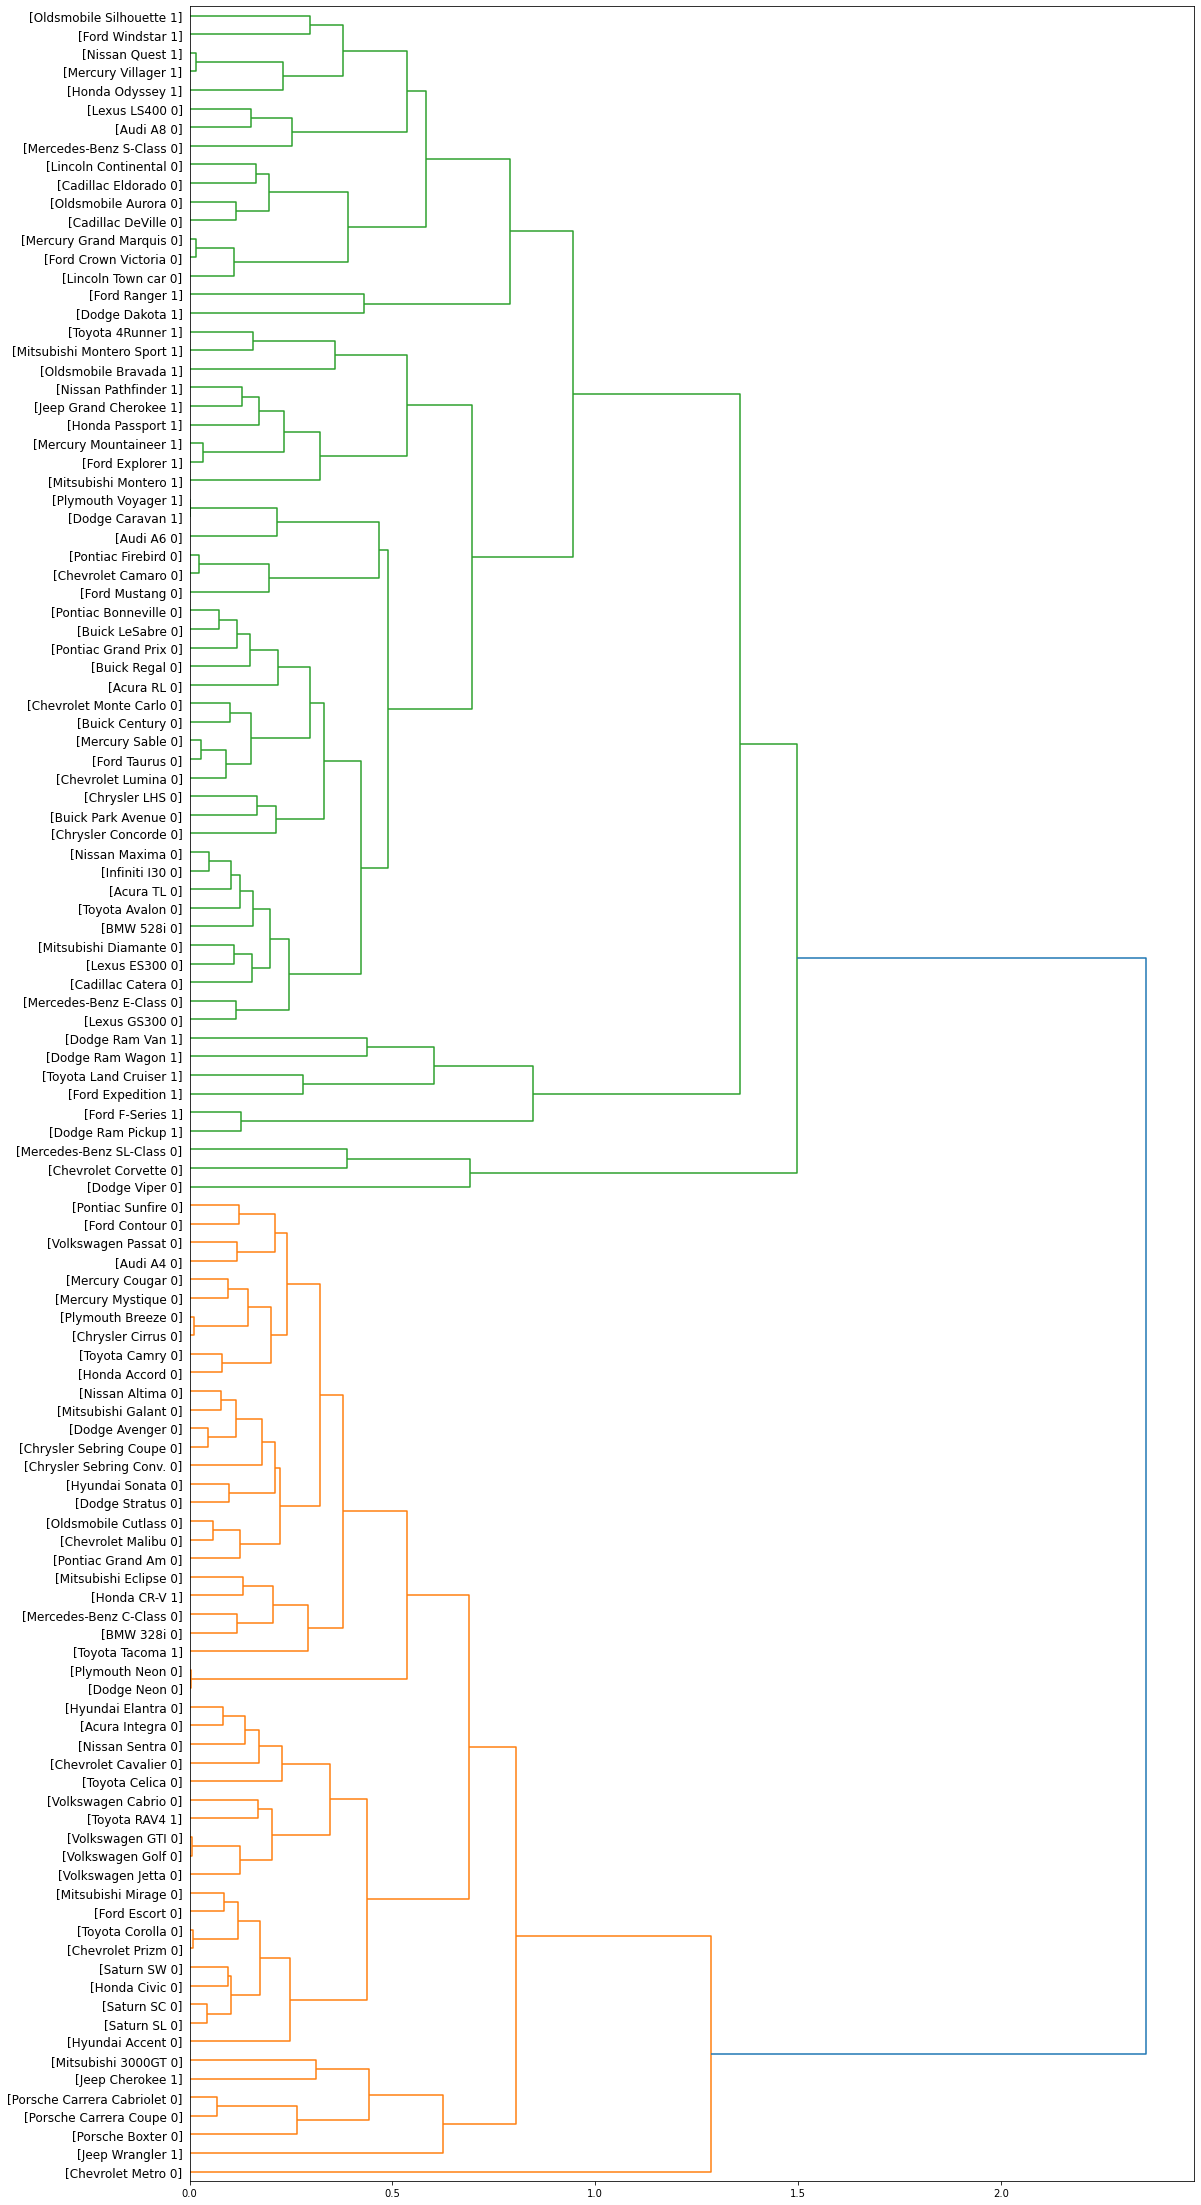

In [84]:
fig = pylab.figure(figsize=(18,40))
def llf(id): #string format operator function
    # label will be returned as str - eg. [Oldsmobile Silhoutte 1]
    return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])) )
    
dendro = hierarchy.dendrogram(Z,  
                              leaf_label_func=llf, 
                              leaf_rotation=0, 
                              leaf_font_size =12,
                              orientation = 'right')

### Build flast cluster model

Essentially, Hierarchical clustering does not require a pre-specified number of clusters. However, in some applications we want a partition of disjoint clusters just as in flat clustering.
So you can use a cutting line:


In [85]:
from scipy.cluster.hierarchy import fcluster

In [86]:
max_d = 3 #threshold to apply for ‘inconsistent’, ‘distance’ or ‘monocrit’,
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int32)

Also, you can determine the number of clusters directly:


In [87]:
k = 6 # max requested number of clusters for ‘maxclust’ or ‘maxclust_monocrit’
clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([1, 5, 5, 1, 5, 6, 1, 5, 5, 5, 5, 5, 6, 6, 5, 1, 1, 5, 5, 5, 3, 1,
       2, 1, 1, 5, 1, 5, 1, 1, 1, 3, 4, 4, 4, 6, 5, 1, 5, 1, 5, 6, 5, 6,
       4, 6, 4, 1, 1, 1, 5, 6, 1, 1, 1, 5, 1, 1, 5, 5, 5, 6, 6, 6, 1, 1,
       1, 5, 1, 5, 5, 1, 1, 5, 6, 5, 6, 1, 5, 6, 3, 1, 1, 5, 6, 5, 1, 6,
       5, 6, 1, 1, 5, 1, 1, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1,
       5, 4, 1, 1, 1, 1, 1], dtype=int32)

### Flat clustering distibution 

#### Scatter plot - mpg vs horse power

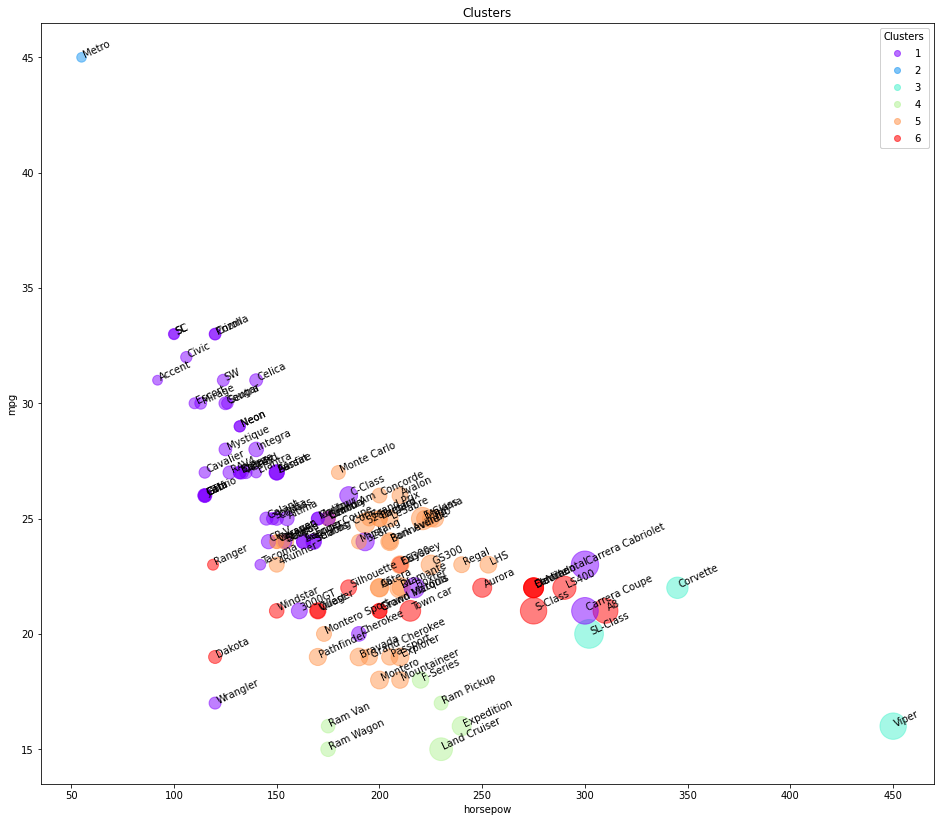

In [88]:
plt.figure(figsize=(16,14))

for i in range(pdf.shape[0]):
    plt.text(pdf.horsepow[i], pdf.mpg[i],str(pdf['model'][i]), rotation=25) 
    
ax = plt.gca() 

scatter =ax.scatter(pdf.horsepow, 
                    pdf.mpg, 
                    s= pdf.price*10, #marker size
                    c=clusters,
                    cmap='rainbow',
                    alpha=0.5)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)

plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

plt.show()

<h2 id="clustering_using_skl">Agglomerative clustering with scikit-learn</h2>

Let's redo it again, but this time using the scikit-learn package:

### Dendrogram with distance matrix

#### Distance matrix using ` euclidean_distances()`

In [89]:
from sklearn.metrics.pairwise import euclidean_distances
import pylab

In [90]:
# skleaen's `euclidean_distances` does not return symmetric and can't be transformed
dist_matrix = euclidean_distances(feature_mtx,feature_mtx) 
print(dist_matrix)

[[0.         0.57777143 0.75455727 ... 0.28530295 0.24917241 0.18879995]
 [0.57777143 0.         0.22798938 ... 0.36087756 0.66346677 0.62201282]
 [0.75455727 0.22798938 0.         ... 0.51727787 0.81786095 0.77930119]
 ...
 [0.28530295 0.36087756 0.51727787 ... 0.         0.41797928 0.35720492]
 [0.24917241 0.66346677 0.81786095 ... 0.41797928 0.         0.15212198]
 [0.18879995 0.62201282 0.77930119 ... 0.35720492 0.15212198 0.        ]]


In [91]:
dist_matrix.shape

(117, 117)

In [92]:
dist_matrix= np.tril(dist_matrix) + np.triu(dist_matrix.T, 1) # make matrix symmetric

dist_matrix = squareform(dist_matrix) #condense the matrix
dist_matrix

array([0.57777143, 0.75455727, 0.2128736 , ..., 0.41797928, 0.35720492,
       0.15212198])

In [93]:
dist_matrix.shape

(6786,)

#### `complete` hierarchy linkage

In [94]:
Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')

#### Dendrogram

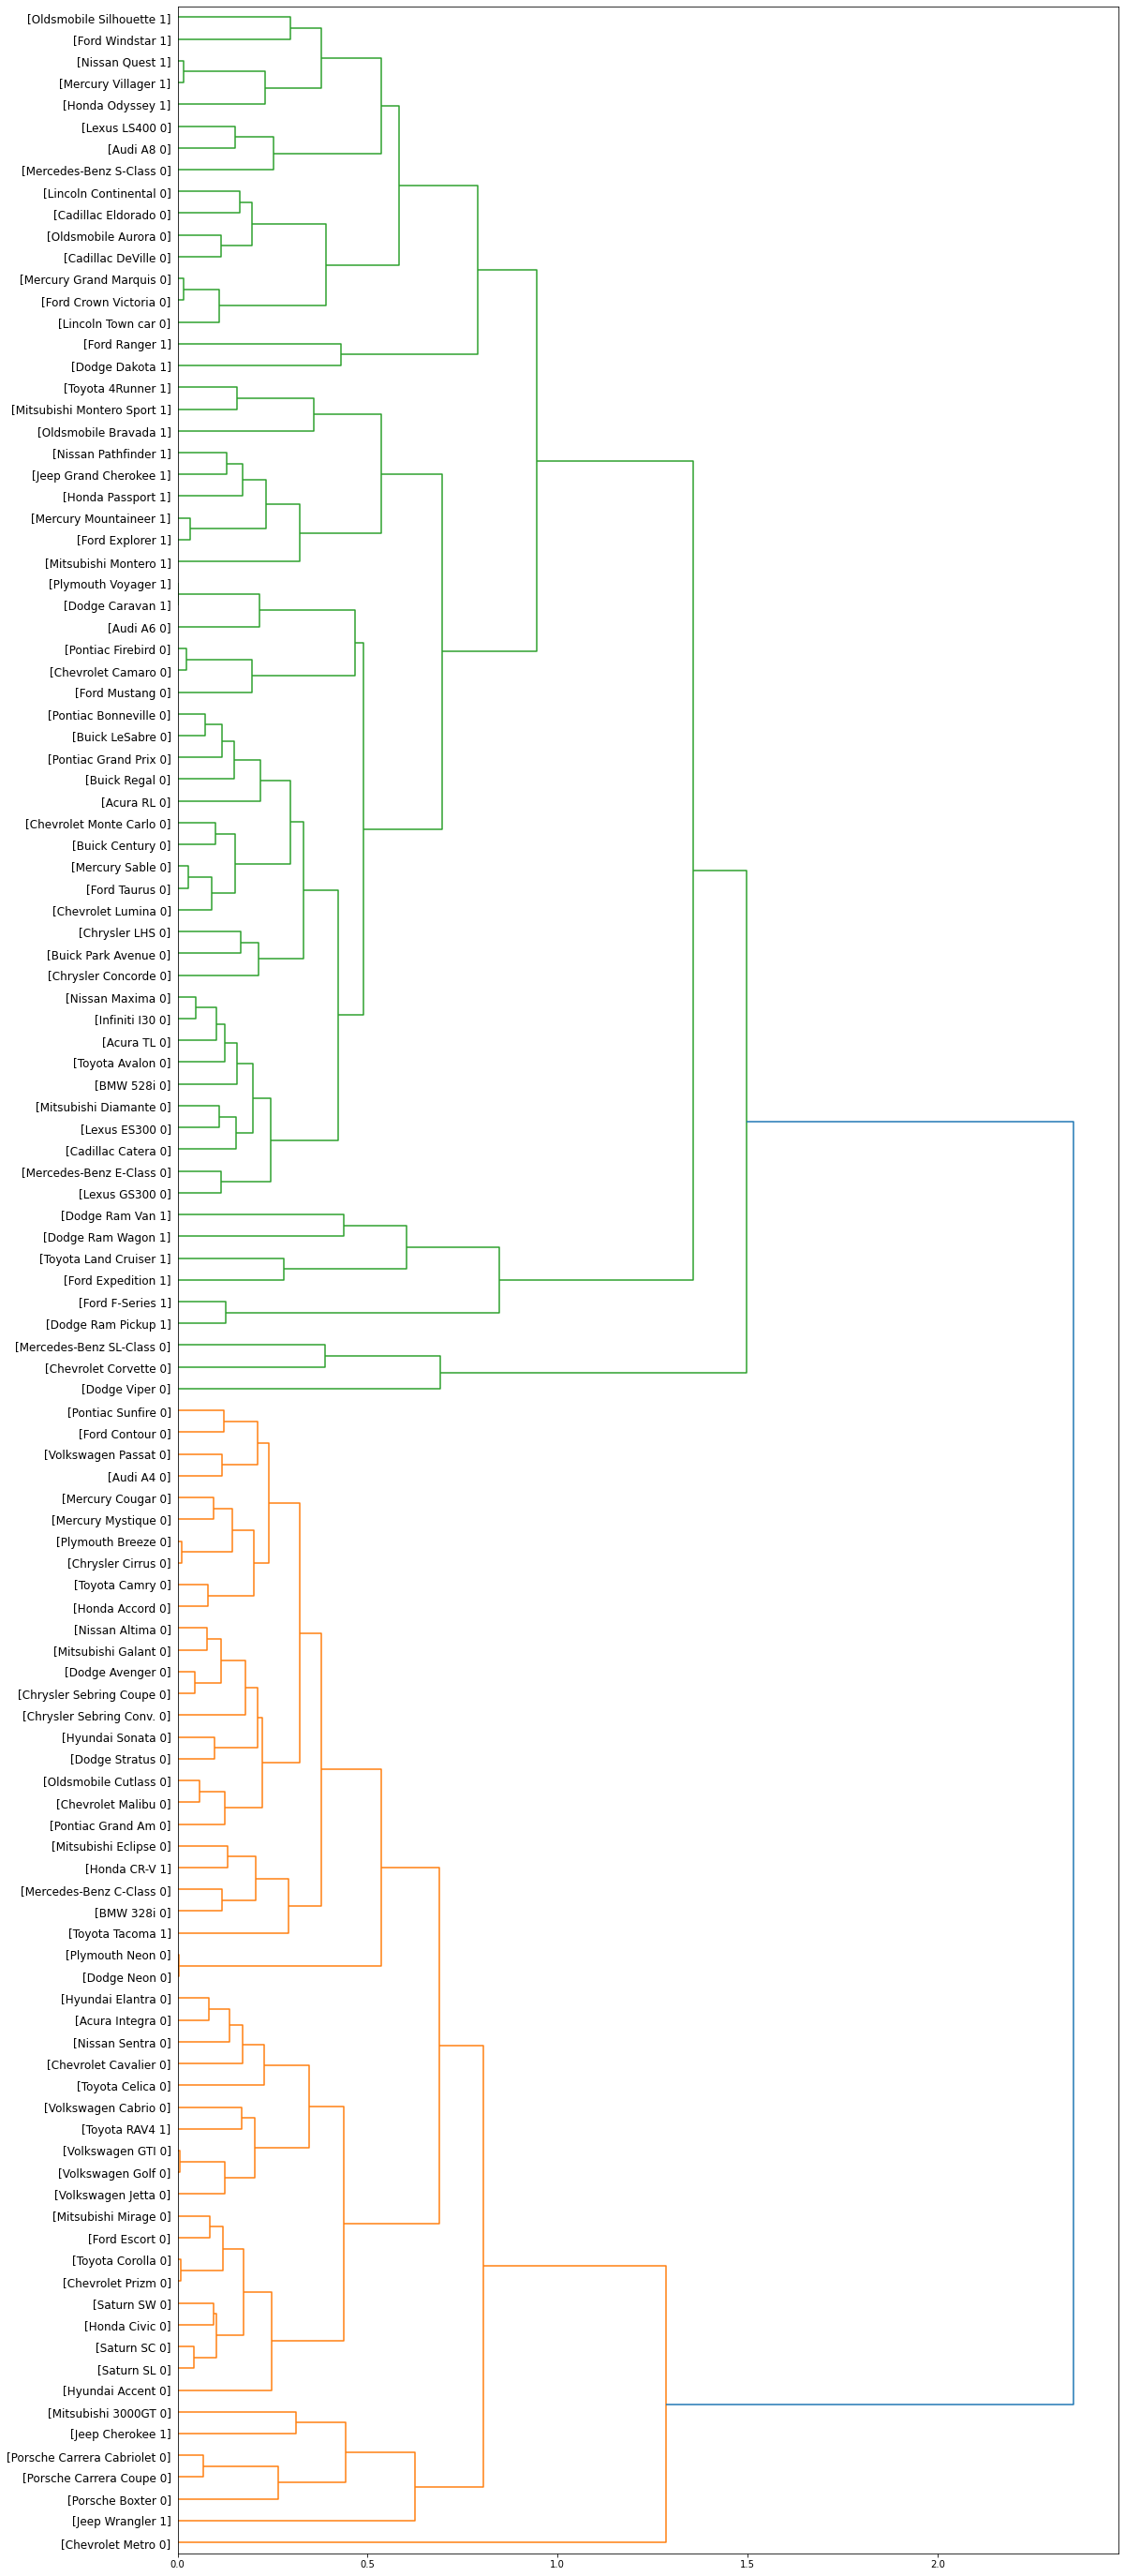

In [95]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])) )
    
dendro = hierarchy.dendrogram(Z_using_dist_matrix, 
                              leaf_label_func=llf, 
                              leaf_rotation=0, 
                              leaf_font_size =12, 
                              orientation = 'right')

### Build Agglomerative model

Now, we can use the 'AgglomerativeClustering' function from scikit-learn library to cluster the dataset. The AgglomerativeClustering performs a hierarchical clustering using a bottom up approach. The linkage criteria determines the metric used for the merge strategy:

*   Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
*   Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
*   Average linkage minimizes the average of the distances between all observations of pairs of clusters.


In [96]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(feature_mtx) # turn 1D to 2D array for input 

agglom.labels_

array([1, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 1, 2, 2, 2, 5, 1,
       4, 1, 1, 2, 1, 2, 1, 1, 1, 5, 0, 0, 0, 3, 2, 1, 2, 1, 2, 3, 2, 3,
       0, 3, 0, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 2, 3, 2, 3, 1, 2, 3, 5, 1, 1, 2, 3, 2, 1, 3,
       2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1], dtype=int64)

We can add a new field to our dataframe to show the cluster of each row:

In [97]:
pdf['cluster_'] = agglom.labels_
pdf.head()

manufact    model   sales  resale  type  price  engine_s  horsepow  \
0    Acura  Integra  16.919  16.360   0.0  21.50       1.8     140.0   
1    Acura       TL  39.384  19.875   0.0  28.40       3.2     225.0   
2    Acura       RL   8.588  29.725   0.0  42.00       3.5     210.0   
3     Audi       A4  20.397  22.255   0.0  23.99       1.8     150.0   
4     Audi       A6  18.780  23.555   0.0  33.95       2.8     200.0   

   wheelbas  width  length  curb_wgt  fuel_cap   mpg  lnsales  partition  \
0     101.2   67.3   172.4     2.639      13.2  28.0    2.828        0.0   
1     108.1   70.3   192.9     3.517      17.2  25.0    3.673        0.0   
2     114.6   71.4   196.6     3.850      18.0  22.0    2.150        0.0   
3     102.6   68.2   178.0     2.998      16.4  27.0    3.015        0.0   
4     108.7   76.1   192.0     3.561      18.5  22.0    2.933        0.0   

   cluster_  
0         1  
1         2  
2         2  
3         1  
4         2

### Agglomerative clustering distribution

In [98]:
import matplotlib.cm as cm

<details><summary>Click here for lecture solution</summary>

```python
n_clusters = agglom.n_clusters_ # or max(agglom.labels_)+1 
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(np.unique(agglom.labels_)) # or list(range(0, n_clusters)) 

plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.cluster_ == label]
    for i in subset.index:
            plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)

plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

plt.show() 
```

</details>

#### Scatter plot - mpg vs horse power
- horse power as x axis 
- mpg as y axis 
- price as refrence of marker size

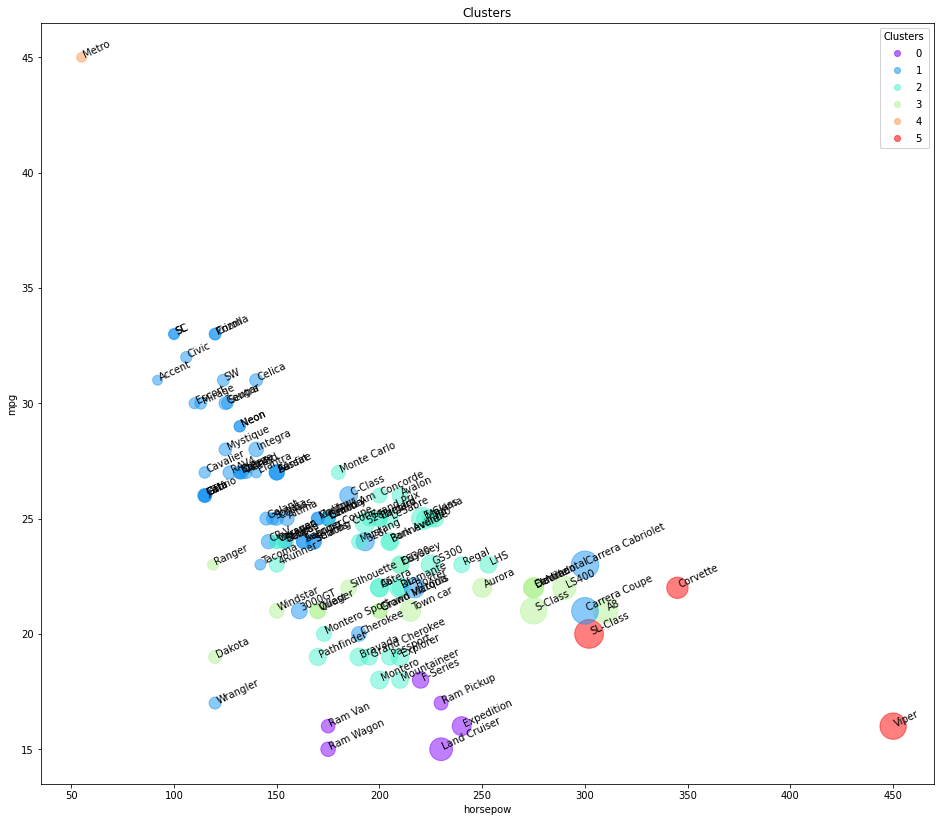

In [99]:
plt.figure(figsize=(16,14))

for i in range(pdf.shape[0]):
    plt.text(pdf.horsepow[i], pdf.mpg[i],str(pdf['model'][i]), rotation=25) 
    
ax = plt.gca() 

scatter =ax.scatter(pdf.horsepow, 
                    pdf.mpg, 
                    s= pdf.price*10, #marker size
                    c=pdf.cluster_,
                    cmap='rainbow',
                    alpha=0.5)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)

plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

plt.show()

As you can see, we are seeing the distribution of each cluster using the scatter plot, but it is not very clear where is the centroid of each cluster. Moreover, there are 2 types of vehicles in our dataset, "truck" (value of 1 in the type column) and "car" (value of 0 in the type column). So, we use them to distinguish the classes, and summarize the cluster. First we count the number of cases in each group:


### Group data to its type and respected cluster label using `groupby()`

In [100]:
pdf.groupby(['cluster_','type'])['cluster_'].count()

cluster_  type
0         1.0      6
1         0.0     47
          1.0      5
2         0.0     27
          1.0     11
3         0.0     10
          1.0      7
4         0.0      1
5         0.0      3
Name: cluster_, dtype: int64

Now we can look at the characteristics of each cluster:


In [101]:
agg_cars = pdf.groupby(['cluster_','type'])[['horsepow','engine_s','mpg','price']].mean()
agg_cars

horsepow  engine_s        mpg      price
cluster_ type                                            
0        1.0   211.666667  4.483333  16.166667  29.024667
1        0.0   146.531915  2.246809  27.021277  20.306128
         1.0   145.000000  2.580000  22.200000  17.009200
2        0.0   203.111111  3.303704  24.214815  27.750593
         1.0   182.090909  3.345455  20.181818  26.265364
3        0.0   256.500000  4.410000  21.500000  42.870400
         1.0   160.571429  3.071429  21.428571  21.527714
4        0.0    55.000000  1.000000  45.000000   9.235000
5        0.0   365.666667  6.233333  19.333333  66.010000

#### Groupped data frame slicing tutorial 

##### Accesing index value practice

In [102]:
agg_cars.index

MultiIndex([(0, 1.0),
            (1, 0.0),
            (1, 1.0),
            (2, 0.0),
            (2, 1.0),
            (3, 0.0),
            (3, 1.0),
            (4, 0.0),
            (5, 0.0)],
           names=['cluster_', 'type'])

In [103]:
agg_cars.index[5][0] #fifth row, first column

3

##### Accesing column value practice

In [104]:
agg_cars.values

array([[211.66666667,   4.48333333,  16.16666667,  29.02466667],
       [146.53191489,   2.24680851,  27.0212766 ,  20.30612766],
       [145.        ,   2.58      ,  22.2       ,  17.0092    ],
       [203.11111111,   3.3037037 ,  24.21481481,  27.75059259],
       [182.09090909,   3.34545455,  20.18181818,  26.26536364],
       [256.5       ,   4.41      ,  21.5       ,  42.8704    ],
       [160.57142857,   3.07142857,  21.42857143,  21.52771429],
       [ 55.        ,   1.        ,  45.        ,   9.235     ],
       [365.66666667,   6.23333333,  19.33333333,  66.01      ]])

In [105]:
agg_cars.values[:,0] # all rows in first column 

array([211.66666667, 146.53191489, 145.        , 203.11111111,
       182.09090909, 256.5       , 160.57142857,  55.        ,
       365.66666667])

### Agglomerative clustering distribution

#### Scatter plot - mpg vs hores power (group by clusters and type , then take the average)

It is obvious that we have 3 main clusters with the majority of vehicles in those.

**Cars**:

*   Cluster 1: with almost high mpg, and low in horsepower.

*   Cluster 2: with good mpg and horsepower, but higher price than average.

*   Cluster 3: with low mpg, high horsepower, highest price.

**Trucks**:

*   Cluster 1: with almost highest mpg among trucks, and lowest in horsepower and price.
*   Cluster 2: with almost low mpg and medium horsepower, but higher price than average.
*   Cluster 3: with good mpg and horsepower, low price.

Please notice that we did not use **type**  and **price** of cars in the clustering process, but Hierarchical clustering could forge the clusters and discriminate them with quite a high accuracy.


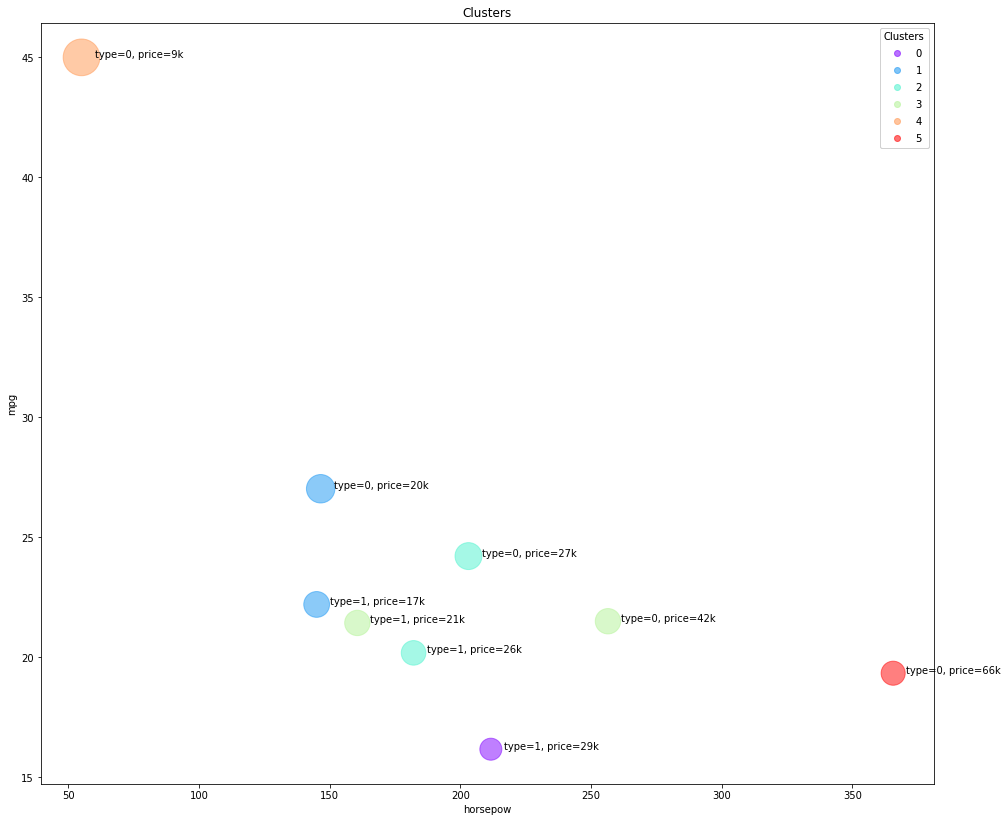

In [106]:
plt.figure(figsize=(16,14))  

label = []
for idx, value in enumerate (agg_cars.index):
    #print(idx,value)
    txt='type=' + str(int(value[1])) + ', price='+str(int(agg_cars.values[idx][3]))+'k'
    plt.text(agg_cars.values[idx,0]+5, agg_cars.values[idx,2], txt)
ax = plt.gca()     
scatter = ax.scatter(agg_cars.values[:,0], 
                     agg_cars.values[:,2], 
                     agg_cars.values[:,2]*30, 
                     c=[value[0] for pos, value in enumerate (agg_cars.index)],
                     cmap='rainbow', 
                     alpha=0.5)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)

plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

plt.show()

<details><summary>Click here for lecture solution</summary>

``` python
n_clusters = agglom.n_clusters_ # or max(agglom.labels_)+1 
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(np.unique(agglom.labels_)) # or list(range(0, n_clusters))

plt.figure(figsize=(16,10))

for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*20, c=color, label='cluster'+str(label))

    plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')
plt.show()
```
</details>